# **Oleksiy's Problog Agent Analysis**

### Libraries


In [64]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Functions

In [65]:
def analyse(path_file):
    match_files = glob.glob(path_file)
    match_stats = []
    round_stats = []
    
    # Data loading remains the same
    for file in match_files:
        with open(file, 'r') as f:
            data = json.load(f)
            match_stats.append({
                'wins': data['wins'],
                'losses': data['losses'],
                'draws': data['draws'],
                'total_rounds': data['total_rounds_played'],
                'duration': data['duration']
            })
            for round in data['rounds']:
                round_stats.append({
                    'duration': round['duration'],
                    'damage_dealt': round['damage_dealt'],
                    'damage_received': round['damage_received'],
                    'actions_used': round['actions_used'],
                    'remaining_hp': round['my_hps'][-1],
                    'opponent_remaining_hp': round['opponent_hps'][-1]
                })

    matches_df = pd.DataFrame(match_stats)
    rounds_df = pd.DataFrame(round_stats)

    # Print statistics
    num_won = matches_df[matches_df['wins'] > 1].shape[0]
    num_lost = matches_df[matches_df['losses'] > 1].shape[0]
    
    print(f"Win Rate: {num_won / len(matches_df) * 100:.2f}%")
    print(f"Loss Rate: {num_lost / len(matches_df) * 100:.2f}%")

    # Create the main figure first - Changed to 6x2 grid
    fig = plt.figure(figsize=(20, 30))  # Increased height to accommodate extra row
    
    # Plot 1: Overall Match outcome distribution
    ax1 = plt.subplot(6, 2, 1)  # Changed from 5,2 to 6,2
    matches_df['outcome'] = matches_df.apply(
        lambda x: 'Win' if x['wins'] > x['losses'] 
        else ('Draw' if x['wins'] == x['losses'] else 'Loss'), axis=1)
    matches_df['outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1)
    ax1.set_title('Overall Match Outcome Distribution')

    # Plot 2: Landslide outcomes
    ax2 = plt.subplot(6, 2, 2)  # Changed from 5,2 to 6,2
    matches_df['outcome'] = matches_df.apply(
        lambda x: 'Landslide Win' if x['wins'] == 3 
        else ('Landslide Loss' if x['losses'] == 3 else 'Non'), axis=1)
    matches_df['outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax2)
    ax2.set_title('Landslide Match Outcome Distribution')
    
    # Rest of the plots - All changed from 5,2 to 6,2
    ax3 = plt.subplot(6, 2, 3)
    matches_df[['wins', 'losses', 'draws']].sum().plot(kind='bar', ax=ax3)
    ax3.set_title('Match Outcomes')
    ax3.set_ylabel('Count')

    ax4 = plt.subplot(6, 2, 4)
    rounds_df[['damage_dealt', 'damage_received']].mean().plot(kind='bar', ax=ax4)
    ax4.set_title('Average Damage per Round')
    ax4.set_ylabel('Damage')

    ax5 = plt.subplot(6, 2, (5,6))
    action_counts = pd.Series([x for sublist in rounds_df['actions_used'] for x in sublist]).value_counts()
    action_counts.index = [x.replace('_', ' ').title() for x in action_counts.index]
    action_counts.plot(kind='bar', ax=ax5)
    ax5.set_title('Action Usage Frequency')
    ax5.tick_params(axis='x', rotation=45)
    ax5.set_ylabel('Count')

    ax6 = plt.subplot(6, 2, 7)
    rounds_df['duration'].hist(bins=20, ax=ax6)
    ax6.set_title('Round Duration Distribution')
    ax6.set_xlabel('Duration')
    ax6.set_ylabel('Frequency')

    ax7 = plt.subplot(6, 2, 8)
    rounds_df[['remaining_hp', 'opponent_remaining_hp']].mean().plot(kind='bar', ax=ax7)
    ax7.set_title('Remaining HP Distribution')
    ax7.set_ylabel('HP')

    ax8 = plt.subplot(6, 2, 9)
    correlation_matrix = rounds_df[['duration', 'damage_dealt', 'damage_received', 'remaining_hp', 'opponent_remaining_hp']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax8)
    ax8.set_title('Correlation Between Round Metrics')
    ax8.tick_params(axis='x', rotation=45)

    ax9 = plt.subplot(6, 2, 10)
    rounds_df['damage_efficiency'] = rounds_df['damage_dealt'] / rounds_df['damage_received']
    rounds_df['damage_efficiency'].plot(kind='box', ax=ax9)
    ax9.set_title('Damage Efficiency Distribution')
    ax9.set_ylabel('Damage Dealt / Damage Received')

    # Now this works because we have positions 11 and 12 in our 6x2 grid
    ax10 = plt.subplot(6, 2, (11, 12))
    ax10.plot(rounds_df.index, rounds_df['damage_dealt'], label='Damage Dealt')
    ax10.plot(rounds_df.index, rounds_df['damage_received'], label='Damage Received')
    ax10.set_title('Damage Dealt vs Received Over Time')
    ax10.set_xlabel('Round Number')
    ax10.set_ylabel('Damage')
    ax10.legend()

    plt.tight_layout(pad=3.0)
    plt.show()
    
def analyze_inference_and_actions(path_file):
    match_files = glob.glob(path_file)
    
    all_inference_times = []
    all_action_pairs = []
    
    for file in match_files:
        with open(file, 'r') as f:
            data = json.load(f)
            for round in data['rounds']:
                # Collect inference times
                all_inference_times.extend(round['time_to_infer'])
                
                # Collect action pairs
                executed = round['actions_used']
                inferred = round['actions_inferred']
                # Zip only matching lengths in case of mismatch
                all_action_pairs.extend(list(zip(executed[:len(inferred)], inferred)))

    # Calculate statistics first
    mismatches = sum(1 for e, i in all_action_pairs if e != i)
    mismatch_rate = mismatches / len(all_action_pairs) * 100
    avg_inference_time = np.mean(all_inference_times)
    median_inference_time = np.median(all_inference_times)

    # Create figure for all plots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Inference Time Analysis - Distribution
    ax1 = plt.subplot(2, 2, 1)
    ax1.hist(all_inference_times, bins=50, color='skyblue', edgecolor='black')
    ax1.set_title('Distribution of Inference Times')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Frequency')
    ax1.axvline(avg_inference_time, color='red', linestyle='--', label=f'Mean: {avg_inference_time:.4f}s')
    ax1.axvline(median_inference_time, color='green', linestyle='--', label=f'Median: {median_inference_time:.4f}s')
    ax1.legend()

    # 2. Inference Time Trend
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(all_inference_times, color='blue', alpha=0.6)
    ax2.set_title('Inference Time Trend')
    ax2.set_xlabel('Action Number')
    ax2.set_ylabel('Time (seconds)')
    ax2.grid(True, alpha=0.3)

    # 3. Action Comparison - Executed
    executed_actions = [pair[0] for pair in all_action_pairs]
    inferred_actions = [pair[1] for pair in all_action_pairs]
    
    ax3 = plt.subplot(2, 2, 3)
    executed_counts = pd.Series(executed_actions).value_counts().head(10)
    executed_counts.plot(kind='bar', ax=ax3, color='lightgreen')
    ax3.set_title('Top 10 Executed Actions')
    ax3.set_xlabel('Action Type')
    ax3.set_ylabel('Count')
    ax3.tick_params(axis='x', rotation=45)

    # 4. Action Comparison - Inferred
    ax4 = plt.subplot(2, 2, 4)
    inferred_counts = pd.Series(inferred_actions).value_counts().head(10)
    inferred_counts.plot(kind='bar', ax=ax4, color='lightcoral')
    ax4.set_title('Top 10 Inferred Actions')
    ax4.set_xlabel('Action Type')
    ax4.set_ylabel('Count')
    ax4.tick_params(axis='x', rotation=45)

    # Add a suptitle with summary statistics
    plt.suptitle(f'Inference Analysis Summary\nMismatch Rate: {mismatch_rate:.2f}% | '
                 f'Avg Inference Time: {avg_inference_time:.4f}s | '
                 f'Median Inference Time: {median_inference_time:.4f}s',
                 fontsize=12, y=0.95)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDetailed Statistics:")
    print(f"Action Mismatch Rate: {mismatch_rate:.2f}%")
    print(f"Average Inference Time: {avg_inference_time:.4f} seconds")
    print(f"Median Inference Time: {median_inference_time:.4f} seconds")
    print(f"Total Actions Analyzed: {len(all_action_pairs)}")
    

### Marco's Mcts Agent vs Oleksiy's Problog Agent

Win Rate: 100.00%
Loss Rate: 0.00%


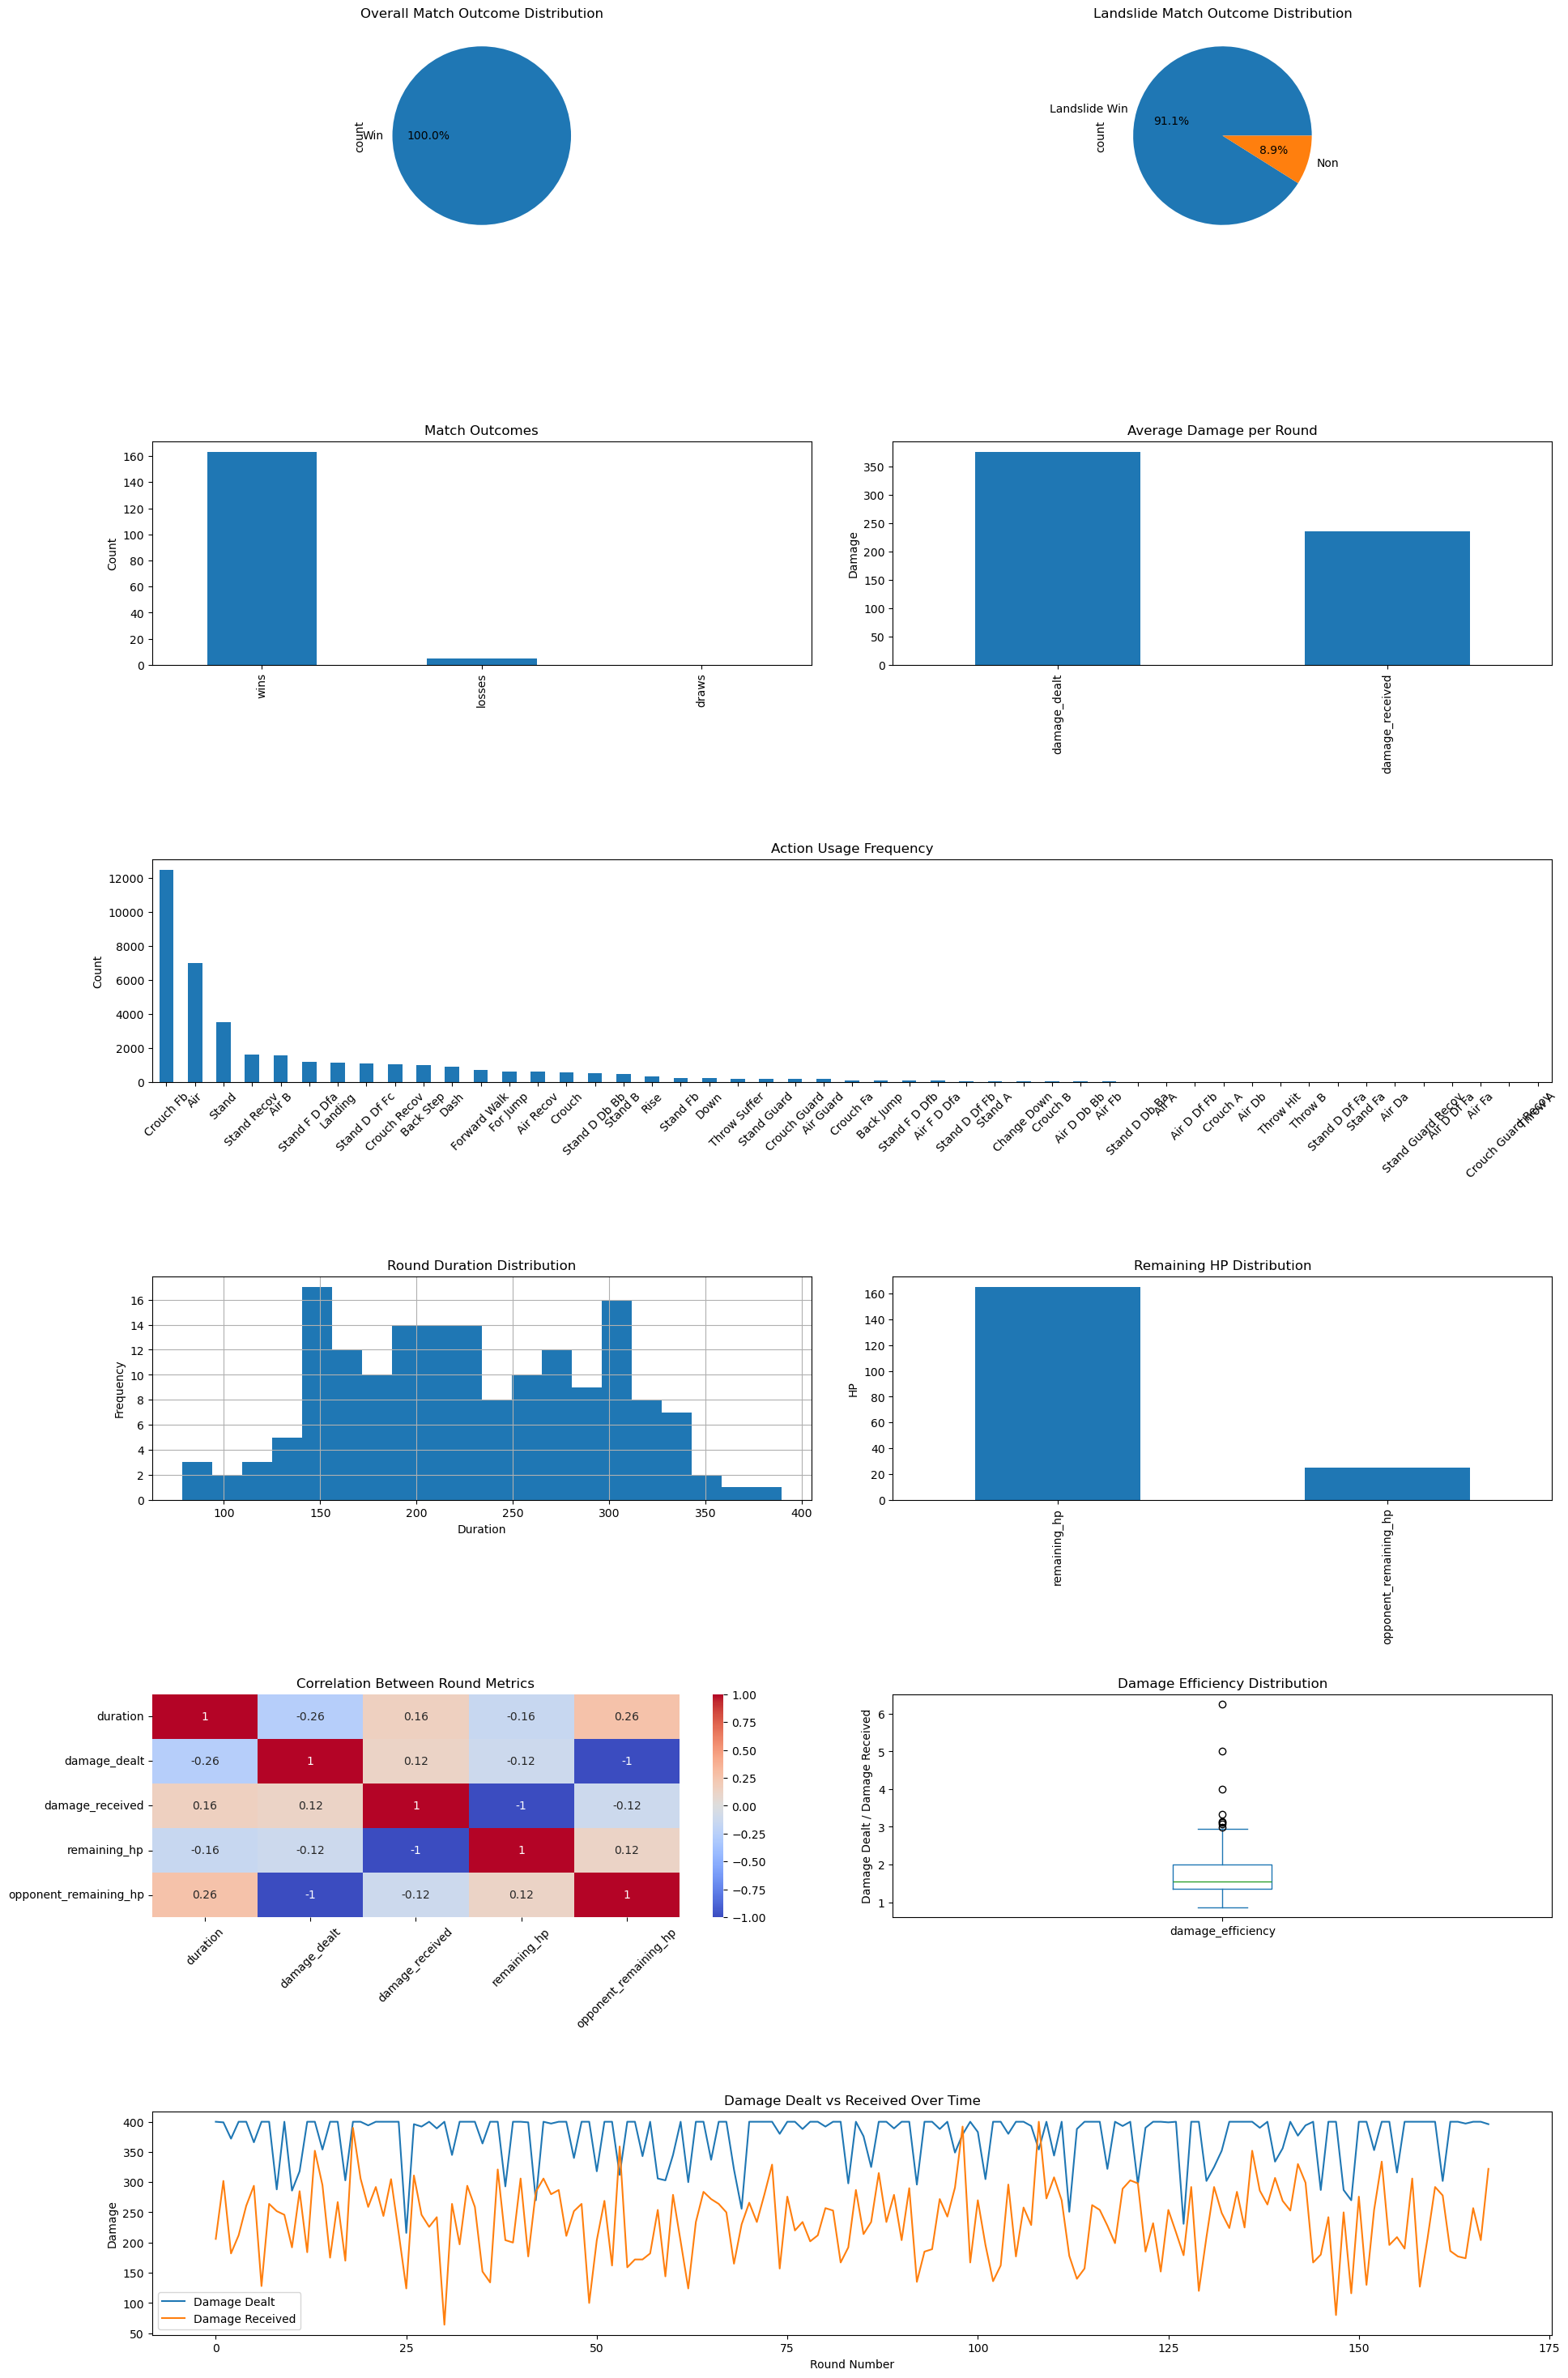

In [66]:
# math_files = glob.glob('stats/MctsAi-vs-ProblogAgent/match-*.json')
analyse('stats/MctsAi-vs-ProblogAgent/match-*.json')


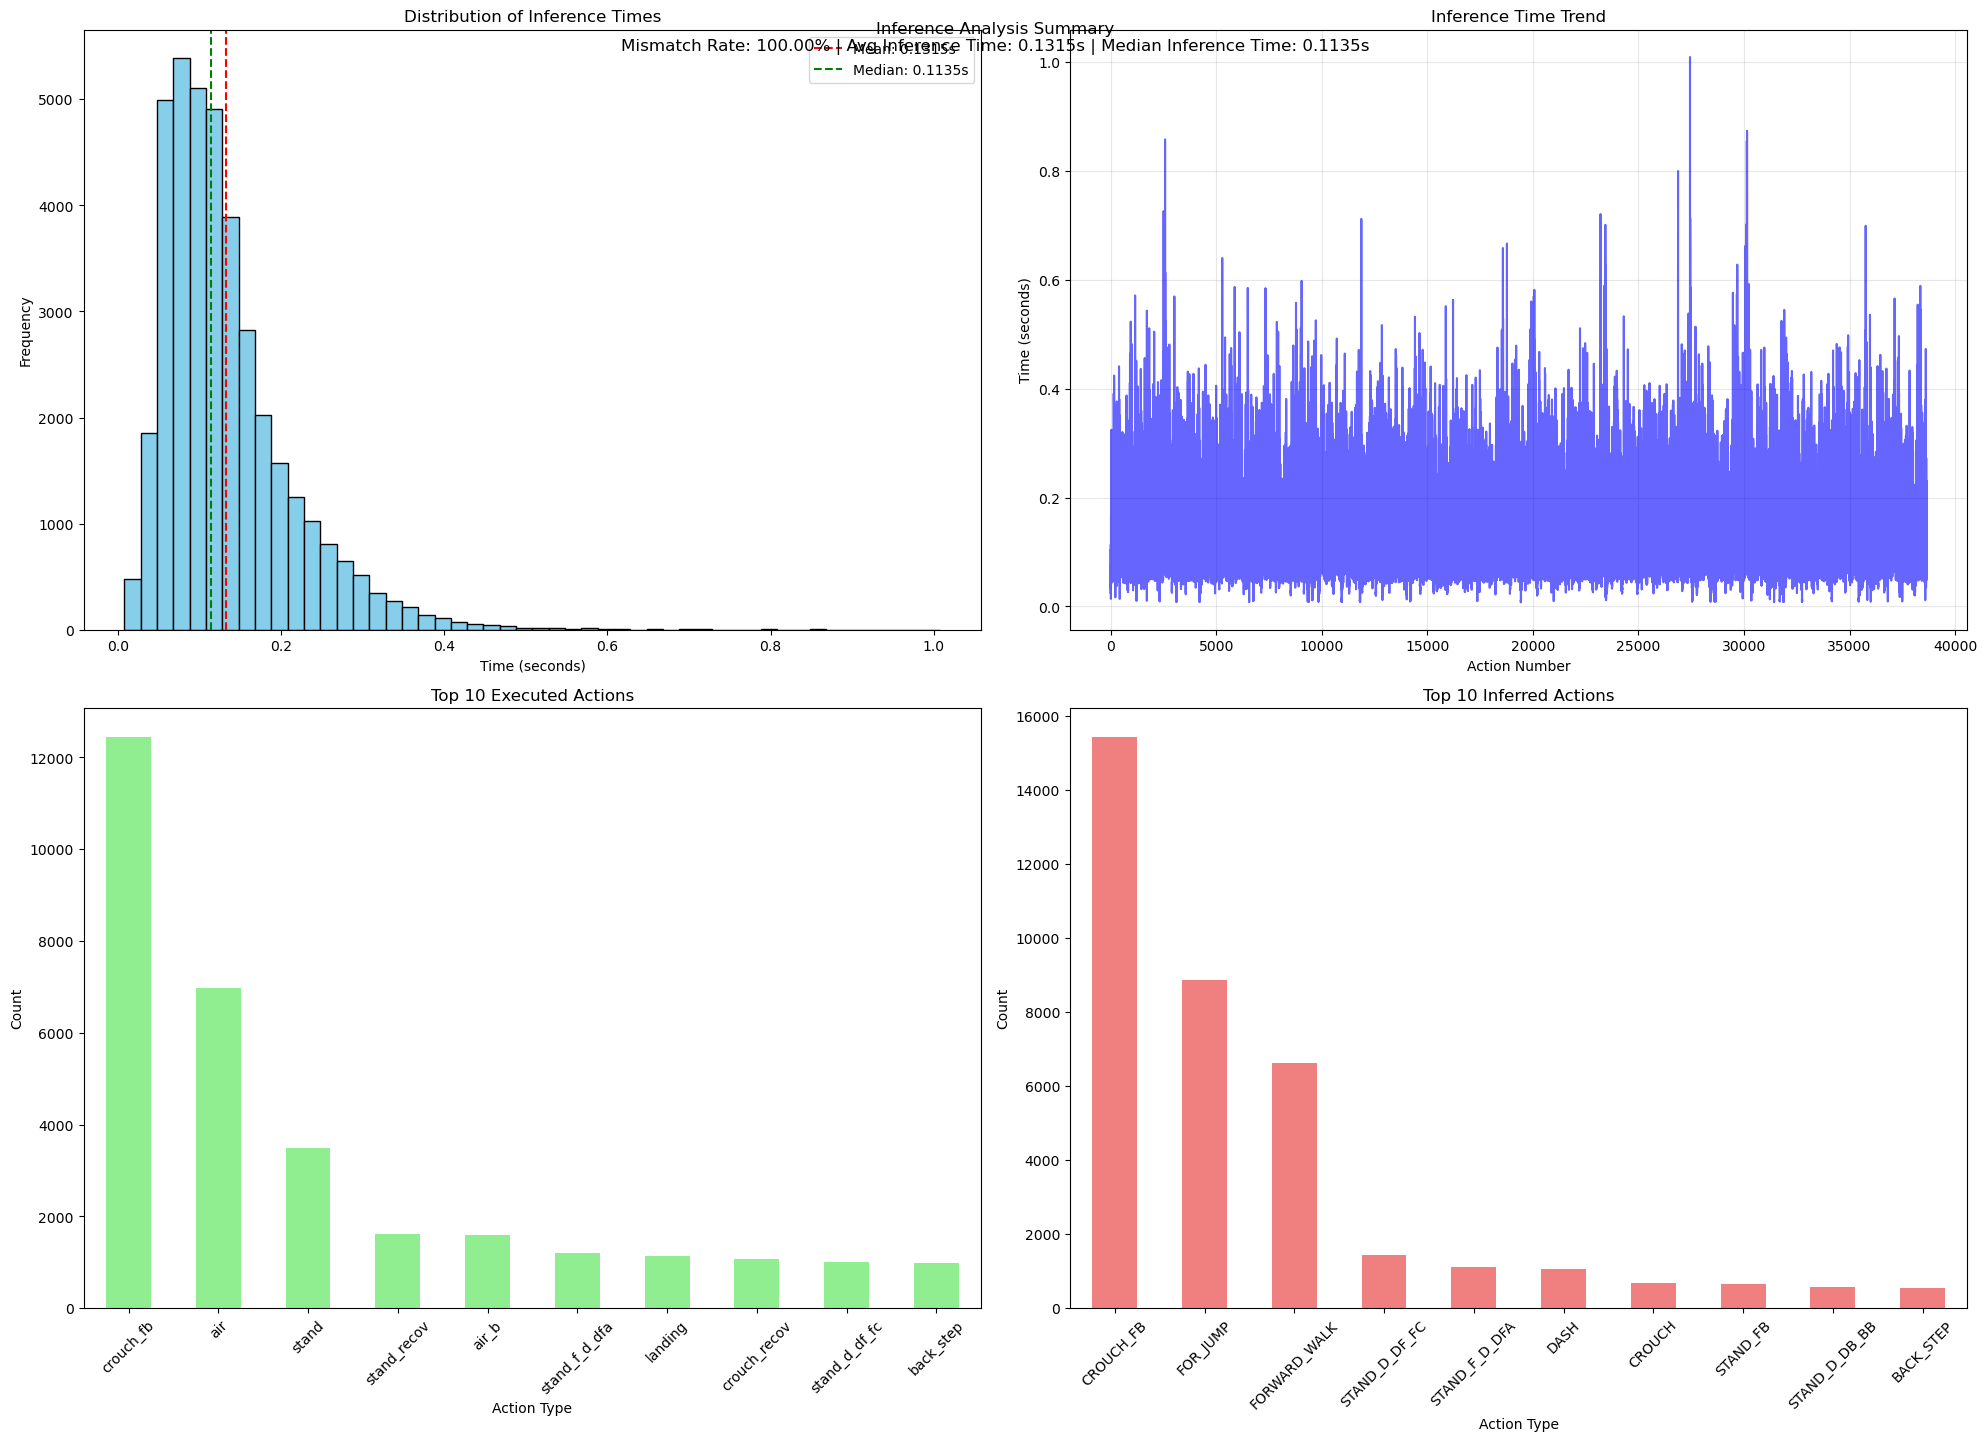


Detailed Statistics:
Action Mismatch Rate: 100.00%
Average Inference Time: 0.1315 seconds
Median Inference Time: 0.1135 seconds
Total Actions Analyzed: 38652


In [67]:
analyze_inference_and_actions('stats/MctsAi-vs-ProblogAgent/match-*.json')

### FightingICE's Mcts Agent vs Oleksiy's Problog Agent

Win Rate: 90.20%
Loss Rate: 9.80%


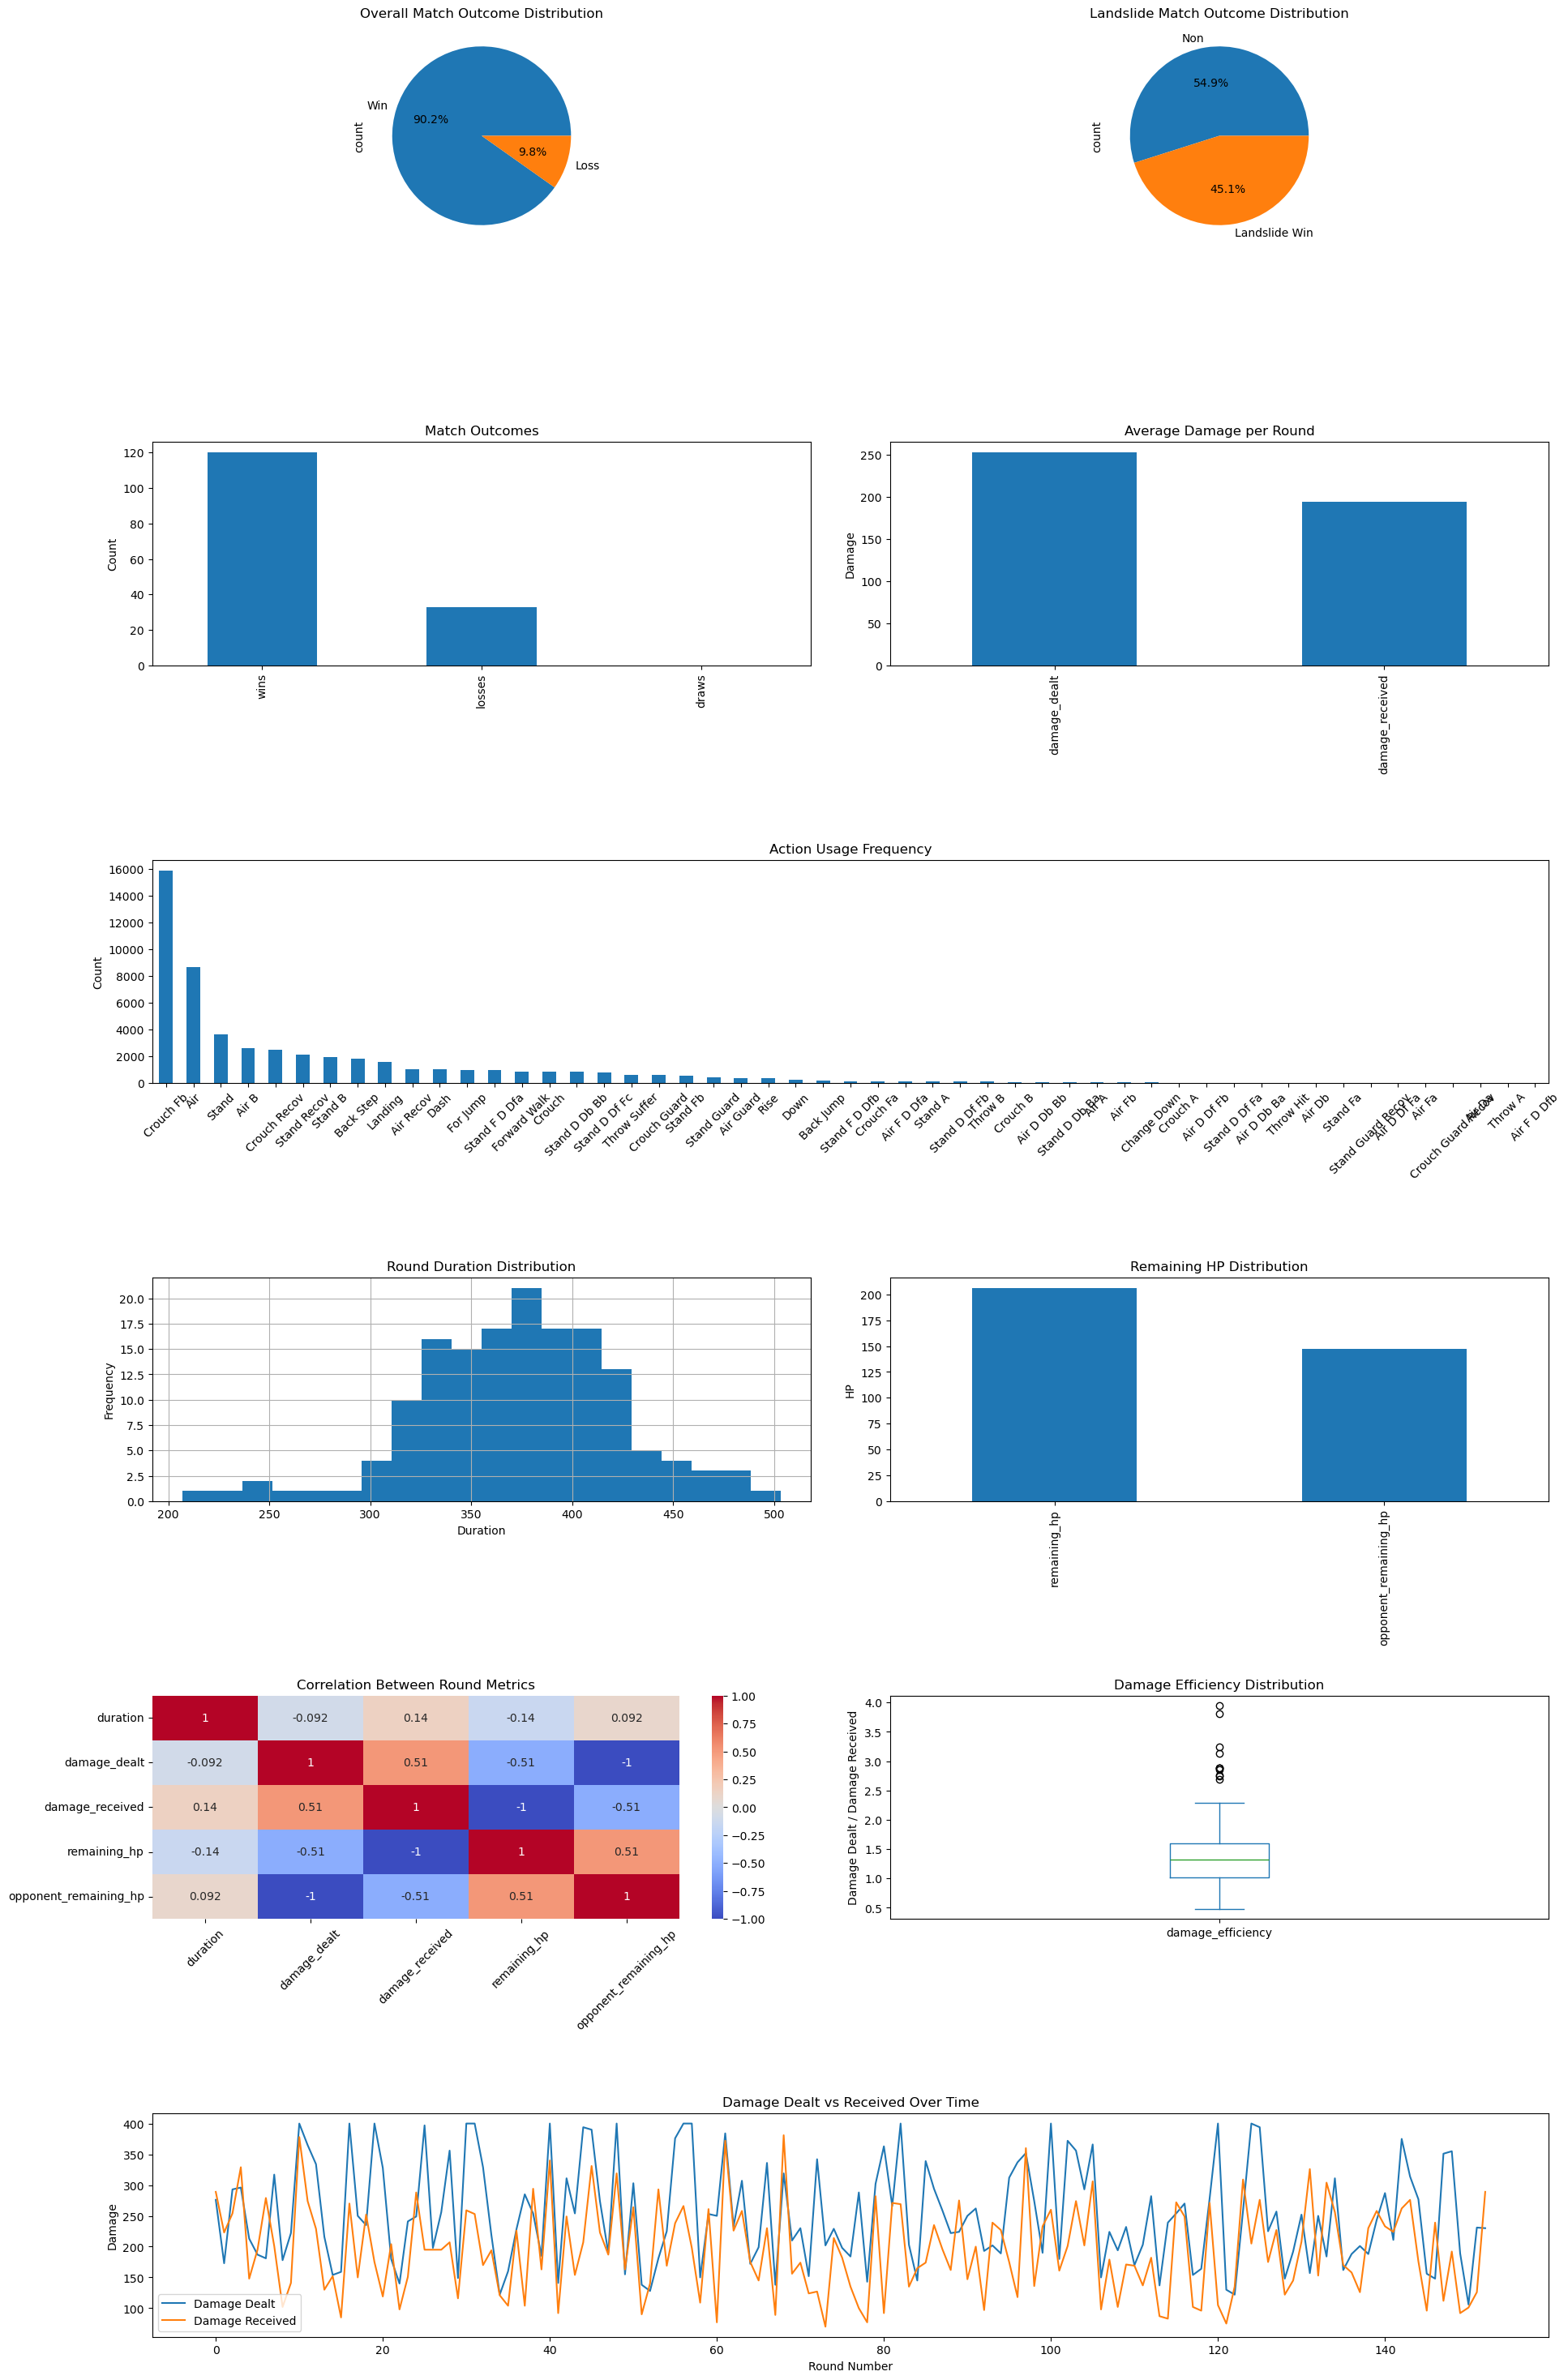

In [68]:
analyse('stats/MctsAi23i-vs-ProblogAgent/match-*.json')

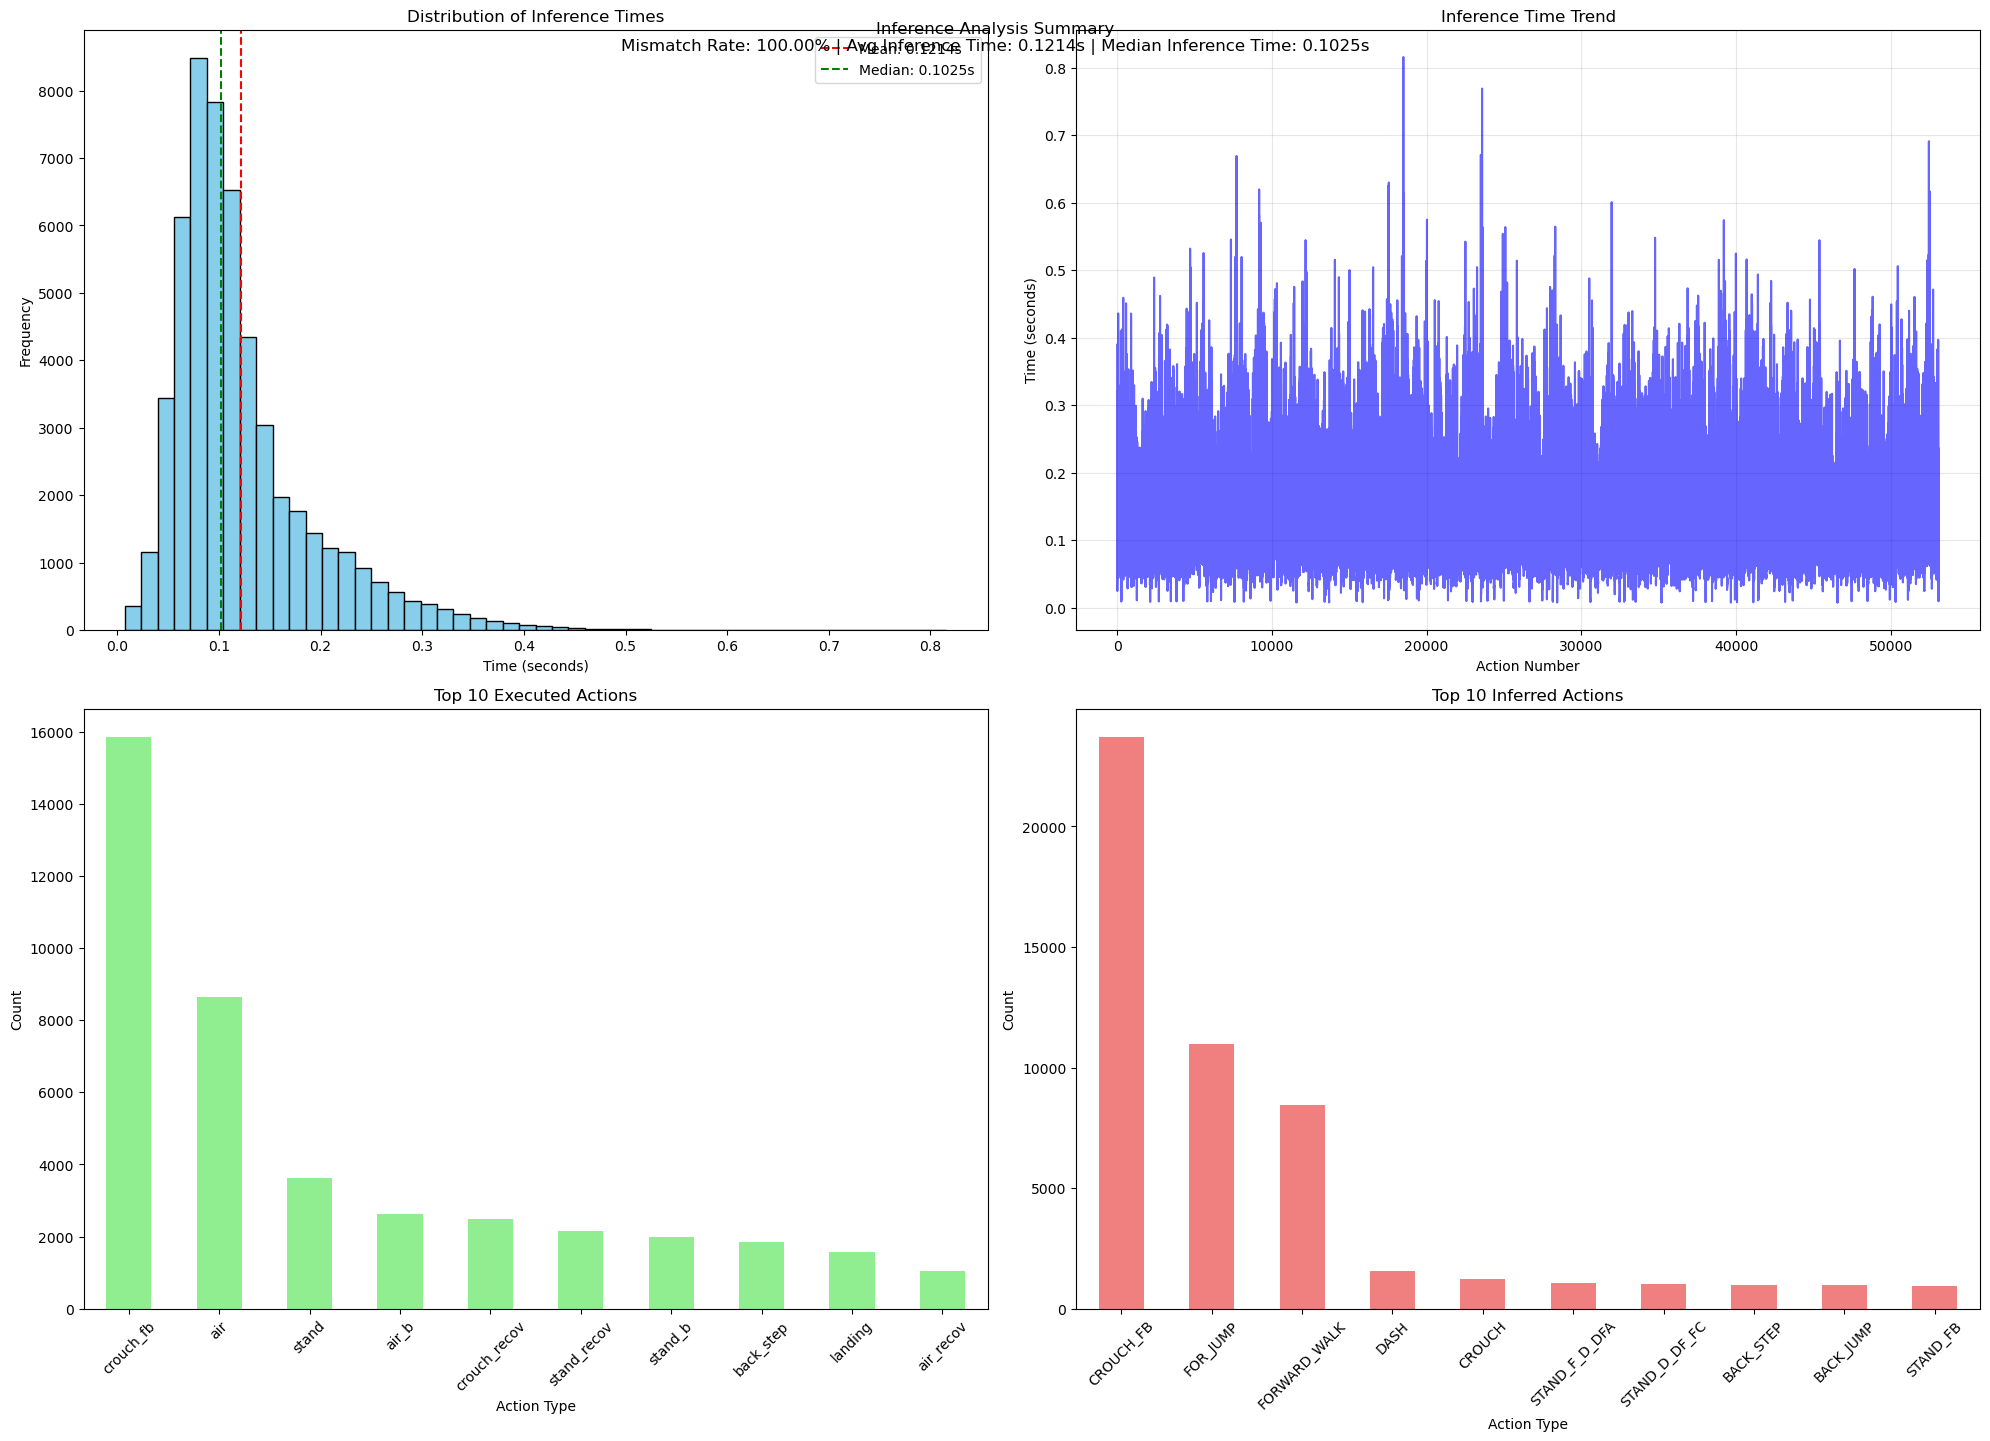


Detailed Statistics:
Action Mismatch Rate: 100.00%
Average Inference Time: 0.1214 seconds
Median Inference Time: 0.1025 seconds
Total Actions Analyzed: 53113


In [69]:
analyze_inference_and_actions('stats/MctsAi23i-vs-ProblogAgent/match-*.json')

### Simone's Prolog Agent vs Oleksiy's Problog Agent

Win Rate: 98.15%
Loss Rate: 1.85%


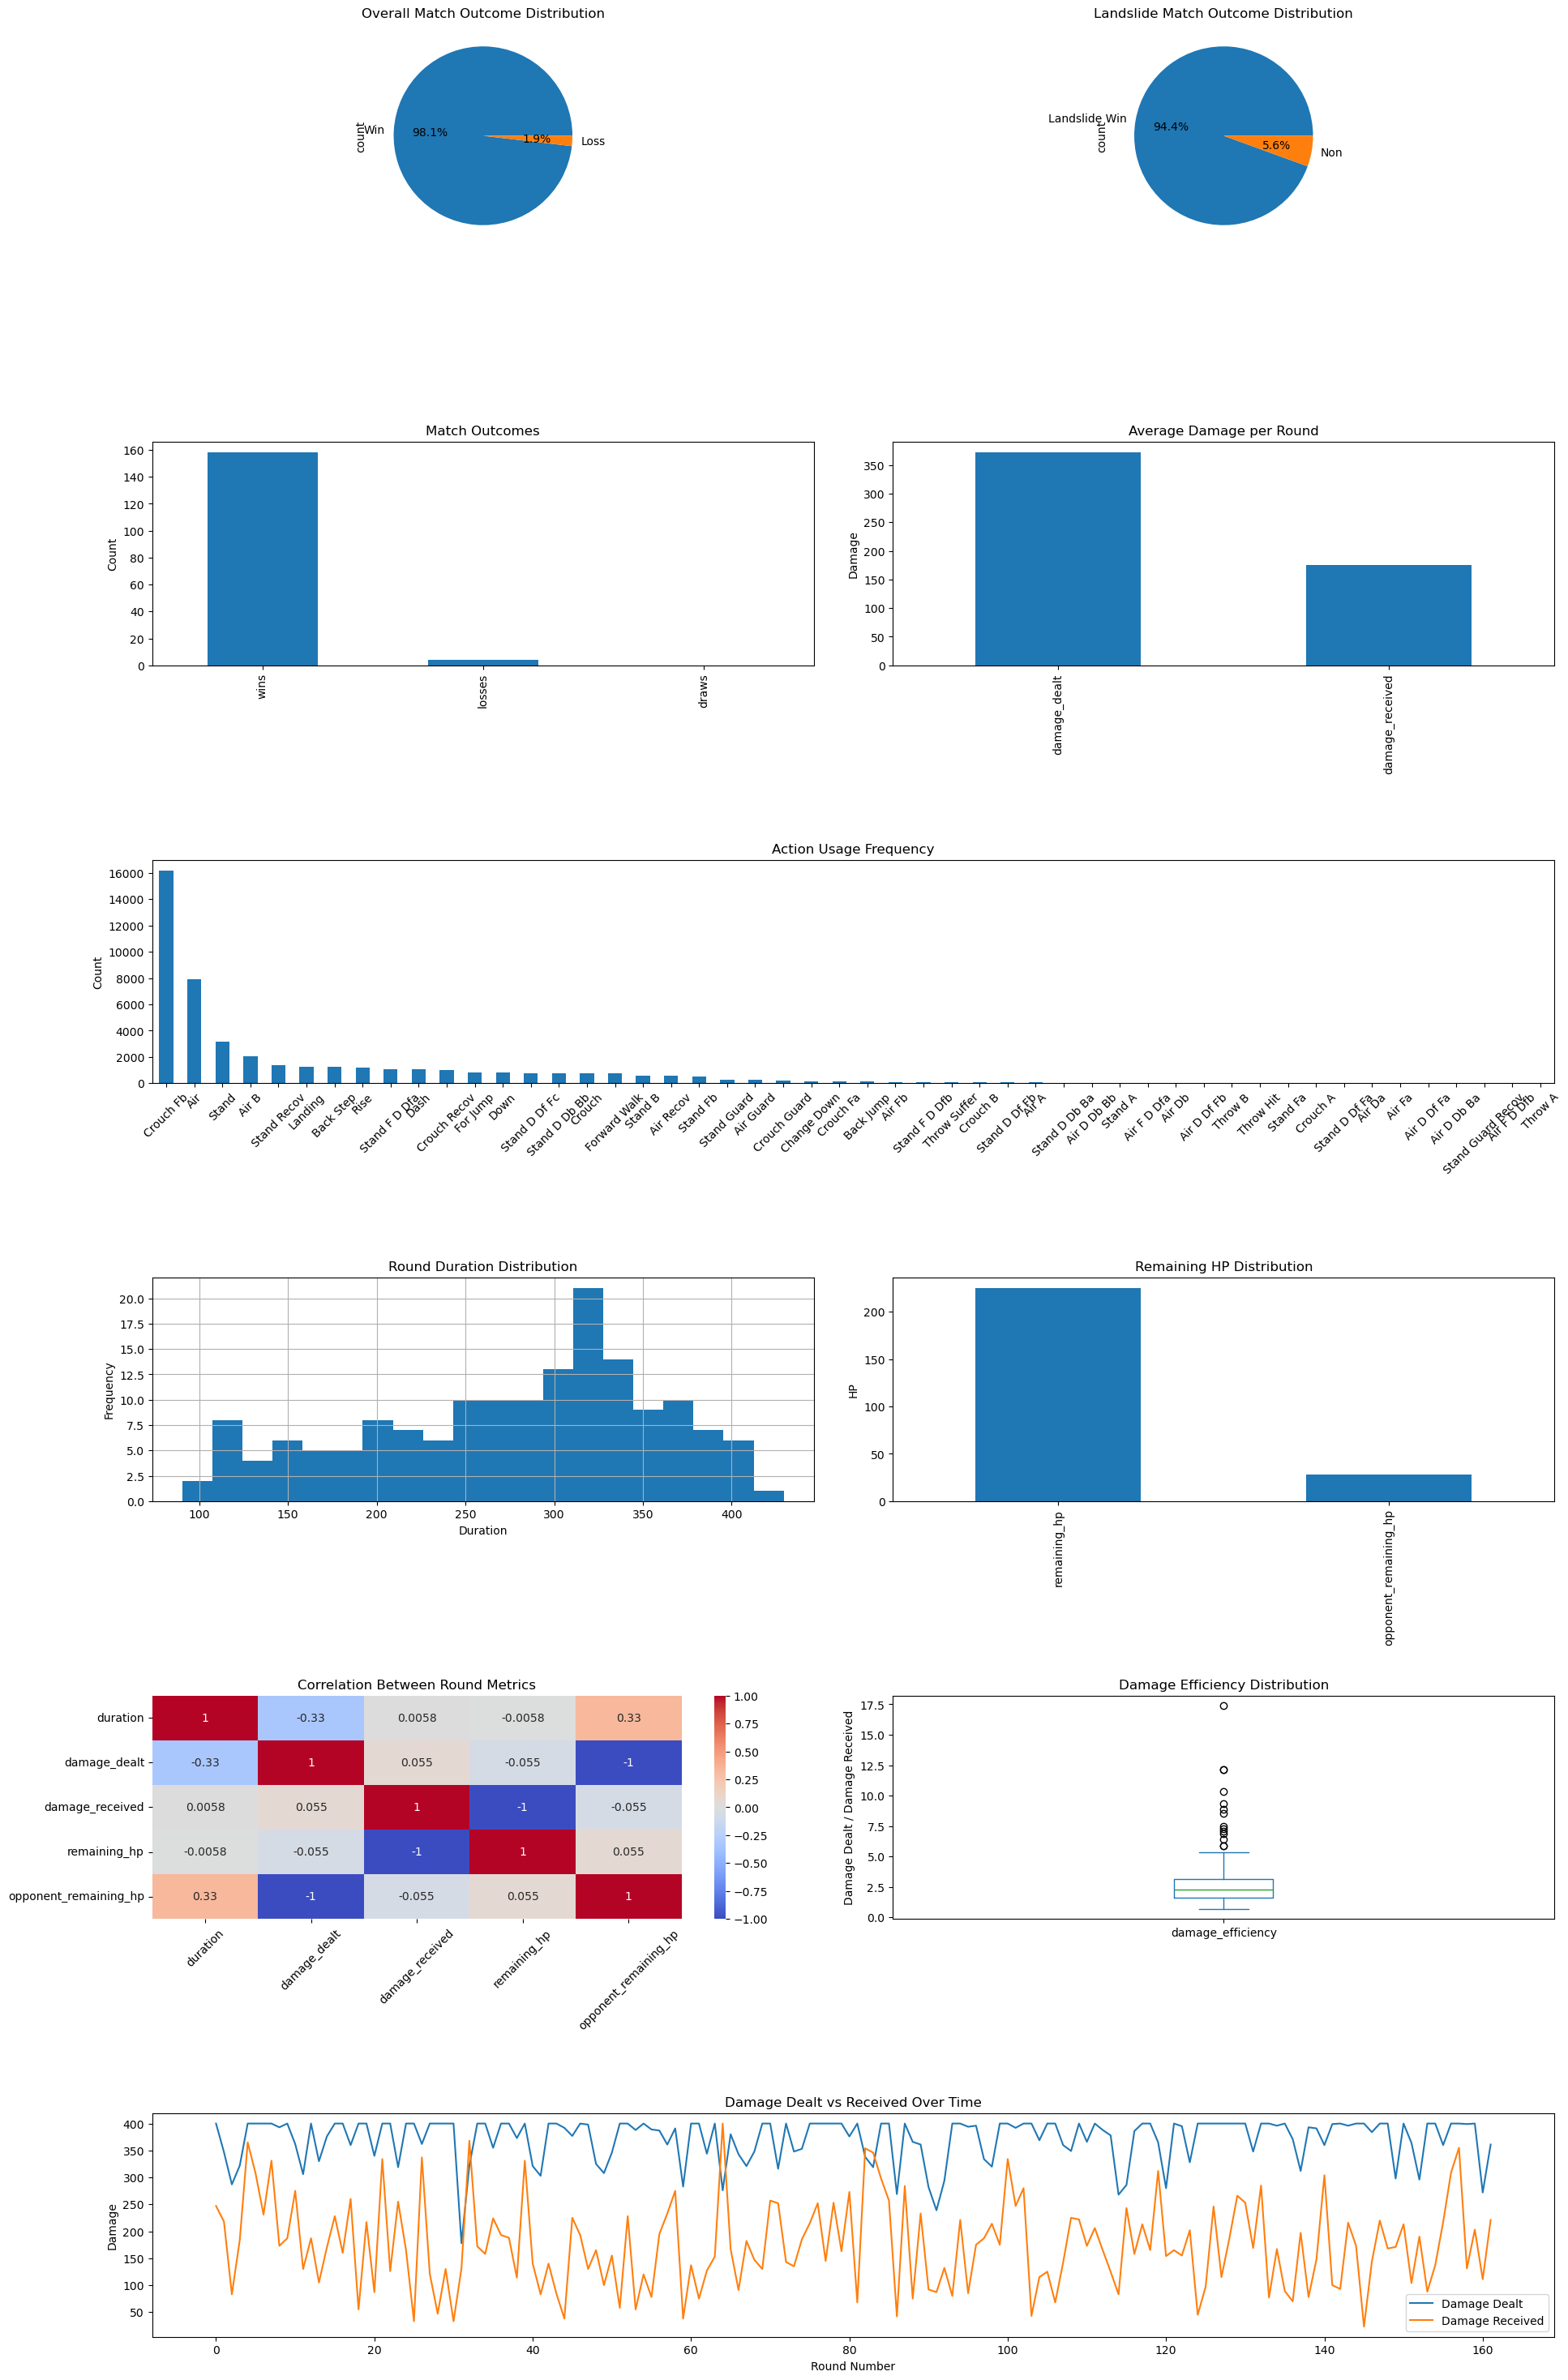

In [70]:
analyse('stats/PrologAI-vs-ProblogAgent/match-*.json')

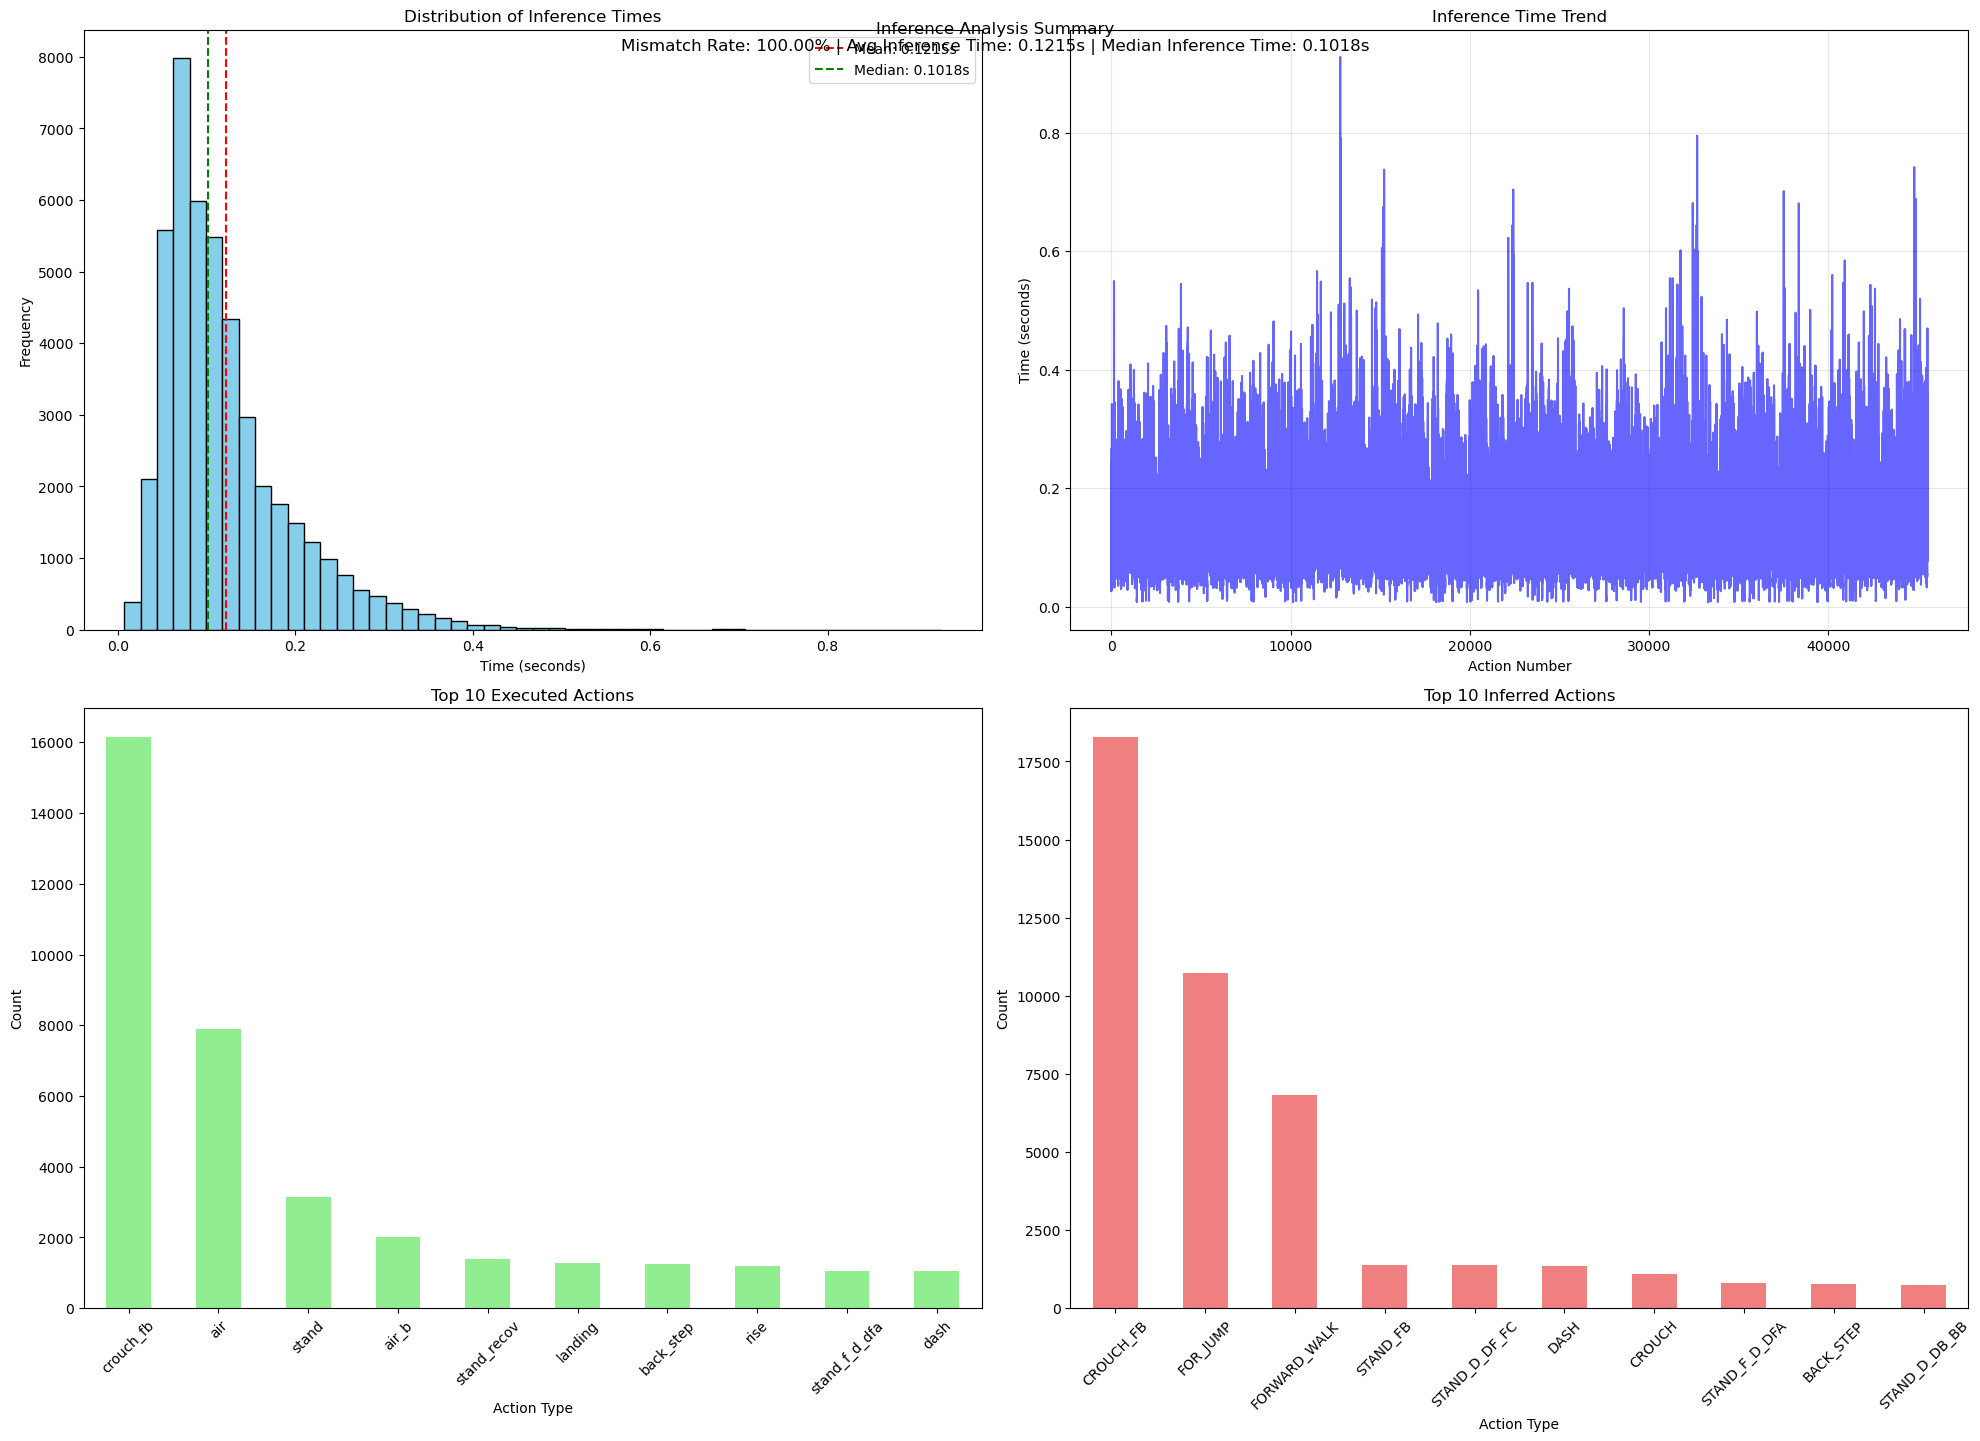


Detailed Statistics:
Action Mismatch Rate: 100.00%
Average Inference Time: 0.1215 seconds
Median Inference Time: 0.1018 seconds
Total Actions Analyzed: 45534


In [71]:
analyze_inference_and_actions('stats/PrologAI-vs-ProblogAgent/match-*.json')